# 1) Install and import libraries

In [1]:
!pip install transformers datasets evaluate seqeval
!pip install onnx onnxruntime optimum

import os
import json
import numpy as np
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=b6e63969f72259e2a49565f5f281996909e8d53596a3a8f34d4f9fe0f2ba4afe
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.

In [2]:
from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments
)

# 2) Configurations & Setup

In [3]:
model_checkpoint = "google/mobilebert-uncased"
num_epochs = 20
batch_size = 32
learning_rate = 0.0005

# Define your labels (modify as needed)
entity_labels = ["HOSP", "PATIENT", "STAFF", "AGE", "DATE", "PHONE", "ID", "EMAIL", "LOC", "PATORG"]
all_labels = ["O"] + entity_labels
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

print("Labels:", all_labels)

# Disable W&B if you don't want to log there (optional)
os.environ["WANDB_DISABLED"] = "true"

Labels: ['O', 'HOSP', 'PATIENT', 'STAFF', 'AGE', 'DATE', 'PHONE', 'ID', 'EMAIL', 'LOC', 'PATORG']


# 3) Load the dataset

In [4]:
# Make sure your JSON files are in your Colab environment or adjust paths accordingly
data_files = {
    "train": "train.json",
    "validation": "validation.json"
}
raw_dataset = load_dataset("json", data_files=data_files)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 4) Alignment function to map entity spans to token labels

In [5]:
def align_spans_to_tokens(examples):
    texts = examples["text"]
    batch_tokenized = tokenizer(
        texts,
        truncation=True,
        return_offsets_mapping=True
    )

    new_labels = []
    for i, offsets in enumerate(batch_tokenized["offset_mapping"]):
        spans = examples["spans"][i]
        span_entities = [(s["start"], s["end"], s["label"]) for s in spans]

        token_labels = ["O"] * len(offsets)

        for span_start, span_end, span_label in span_entities:
            for idx, (token_start, token_end) in enumerate(offsets):
                # Ignore special token offsets, typically (0, 0)
                if token_start == 0 and token_end == 0:
                    continue
                # If there's overlap, assign label
                if token_end > span_start and token_start < span_end:
                    token_labels[idx] = span_label

        label_ids = [label2id[label] for label in token_labels]
        new_labels.append(label_ids)

    batch_tokenized["labels"] = new_labels
    # We don't need offsets once we've created labels
    batch_tokenized.pop("offset_mapping")
    return batch_tokenized

# 5) Apply the alignment to create encoded dataset

In [6]:
encoded_dataset = raw_dataset.map(
    align_spans_to_tokens,
    batched=True,
    remove_columns=raw_dataset["train"].column_names
)

train_dataset = encoded_dataset["train"]
eval_dataset = encoded_dataset["validation"]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/106 [00:00<?, ? examples/s]

# 6) Load model and move to device

In [7]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

# Create data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForTokenClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


# 7) Set up evaluation metric (seqeval)

In [8]:
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for label_ids, pred_ids in zip(labels, predictions):
        # Filter out ignored indices if any (e.g., -100)
        filtered_labels = []
        filtered_preds = []
        for l, p_ in zip(label_ids, pred_ids):
            if l != -100:
                filtered_labels.append(id2label[l])
                filtered_preds.append(id2label[p_])

        true_labels.append(filtered_labels)
        true_predictions.append(filtered_preds)

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }


# 8) Define training arguments

In [9]:
training_args = TrainingArguments(
    output_dir="./mobilebert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",        # <-- Add logging each epoch
    logging_steps=10,                # <-- Or pick a suitable step frequency
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# 9) Create Trainer and start training

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

# Evaluate the final model
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)

# Save final model & tokenizer
trainer.save_model("final_model")
tokenizer.save_pretrained("final_model")

<ipython-input-10-a94afe291c0e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,81676.956500,0.088958,0.898182,0.903108,0.900638,0.975232
2,0.062400,0.129825,0.758779,0.908592,0.826955,0.954799
3,0.037200,0.049613,0.935714,0.957952,0.946703,0.984830
4,0.028200,0.067357,0.933450,0.974406,0.953488,0.984830
5,0.016500,0.049950,0.945133,0.976234,0.960432,0.987307
6,0.012200,0.067167,0.962433,0.983547,0.972875,0.988854
7,0.012100,0.032113,0.967626,0.983547,0.975521,0.991950
8,0.004000,0.046407,0.918403,0.967093,0.942119,0.986068
9,0.002300,0.041322,0.969534,0.989031,0.979186,0.992570
10,0.001800,0.045629,0.967800,0.989031,0.978300,0.991331


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: HOSP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PATIENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: STAFF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: HOSP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PATIENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: STAFF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:

Evaluation metrics: {'eval_loss': 0.03805398568511009, 'eval_precision': 0.9747747747747748, 'eval_recall': 0.9890310786106032, 'eval_f1': 0.9818511796733213, 'eval_accuracy': 0.9919504643962849, 'eval_runtime': 0.446, 'eval_samples_per_second': 237.655, 'eval_steps_per_second': 8.968, 'epoch': 20.0}


('final_model/tokenizer_config.json',
 'final_model/special_tokens_map.json',
 'final_model/vocab.txt',
 'final_model/added_tokens.json',
 'final_model/tokenizer.json')

# Plot graphs

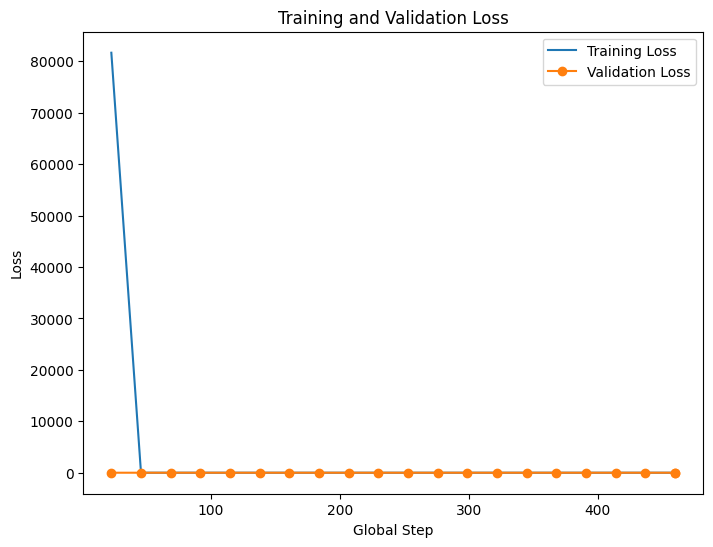

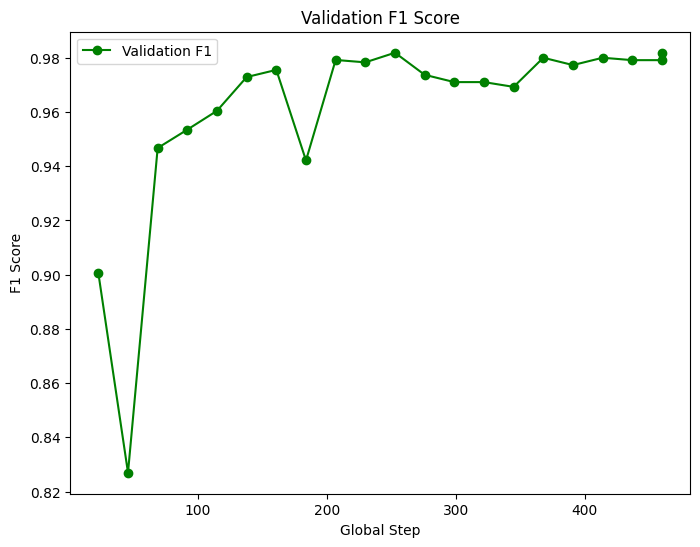

In [23]:
import matplotlib.pyplot as plt

# Extract the log history
log_history = trainer.state.log_history

# 1) Plot Training vs. Validation Loss
train_loss_vals = []
train_steps = []
eval_loss_vals = []
eval_steps = []

for entry in log_history:
    # Training loss entries
    if "loss" in entry and "step" in entry:
        train_loss_vals.append(entry["loss"])
        train_steps.append(entry["step"])
    # Evaluation loss entries
    if "eval_loss" in entry and "step" in entry:
        eval_loss_vals.append(entry["eval_loss"])
        eval_steps.append(entry["step"])

plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_loss_vals, label="Training Loss")
plt.plot(eval_steps, eval_loss_vals, label="Validation Loss", marker='o')
plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# 2) Plot F1 Score (or other metrics) over time
eval_f1_vals = []
eval_f1_steps = []

for entry in log_history:
    if "eval_f1" in entry and "step" in entry:
        eval_f1_vals.append(entry["eval_f1"])
        eval_f1_steps.append(entry["step"])

# Only plot if we actually have F1 data
if eval_f1_vals:
    plt.figure(figsize=(8, 6))
    plt.plot(eval_f1_steps, eval_f1_vals, label="Validation F1", marker='o', color='green')
    plt.xlabel("Global Step")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    plt.show()


# 10) Inference / Testing the Trained Model

In [11]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Load the trained model and tokenizer
model_path = "final_model"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

id2label = model.config.id2label  # Should already be stored in config

# Example input text
test_text = """Immunization Report
Patient Name: Sandamali Herath
Patient ID: 6269540V
Date of Birth: March 15, 2010
Report ID: IMMU7890
Physician Name: Dr.Hemal Senanayake
Date of Report: April 10, 2024

Immunization Record
Vaccine Name	Date Administered	Dose	Site of Administration	Administered By
Hepatitis B	January 20, 2021	0.5 mL	Left Deltoid	Nurse Kamala Selvaraj
Influenza (Flu)	October 5, 2023	0.5 mL	Right Arm	Nurse Nuthara Pathirana
Measles-Mumps-Rubella	April 15, 2021	0.5 mL	Left Thigh	Dr.Hemal Senanayake
Tetanus (Tdap)	June 10, 2022	0.5 mL	Left Deltoid	Nurse Kamala Selvaraj
COVID-19 (Pfizer)	May 12, 2023	0.3 mL	Right Deltoid	Nurse Nuthara Pathirana
Notes
Upcoming Vaccines: HPV vaccine scheduled for June 2024.
Adverse Reactions: None reported for any administered vaccines.
Clinic Information:
Kalubowila Main Hospital
No 1, Kalubowila Hospital, Kalubowila, Colombo
Contact: (+94)6281110123
"""

# Tokenize
inputs = tokenizer(test_text, return_tensors="pt", truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predictions = torch.argmax(logits, dim=2).cpu().numpy()[0]

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().numpy()[0])

# Print token and predicted label
for token, pred_id in zip(tokens, predictions):
    label = id2label[pred_id]
    # Skip special tokens
    if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        print(f"{token}\t{label}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


im	O
##mun	O
##ization	O
report	O
patient	O
name	O
:	O
sand	PATIENT
##ama	PATIENT
##li	PATIENT
her	PATIENT
##ath	PATIENT
patient	O
id	O
:	O
62	ID
##6	ID
##9	ID
##54	ID
##0	ID
##v	ID
date	O
of	O
birth	O
:	O
march	DATE
15	DATE
,	DATE
2010	DATE
report	O
id	O
:	O
im	ID
##mu	ID
##7	ID
##8	ID
##90	ID
physician	O
name	O
:	O
dr	STAFF
.	STAFF
hem	STAFF
##al	STAFF
sen	STAFF
##ana	STAFF
##ya	STAFF
##ke	STAFF
date	O
of	O
report	O
:	O
april	DATE
10	DATE
,	DATE
202	DATE
##4	DATE
im	O
##mun	O
##ization	O
record	O
vaccine	O
name	O
date	O
administered	O
dose	O
site	O
of	O
administration	O
administered	O
by	O
hepatitis	O
b	O
january	DATE
20	DATE
,	DATE
2021	DATE
0	O
.	O
5	O
ml	O
left	O
del	O
##to	O
##id	O
nurse	STAFF
kamal	STAFF
##a	STAFF
se	STAFF
##lva	STAFF
##raj	STAFF
influenza	O
(	O
flu	O
)	O
october	DATE
5	DATE
,	DATE
202	DATE
##3	DATE
0	O
.	O
5	O
ml	O
right	O
arm	O
nurse	STAFF
nut	STAFF
##hara	STAFF
path	STAFF
##ira	STAFF
##na	STAFF
me	O
##as	O
##les	O
-	O
mum	O
##ps	O
-	O
rub	O
##ella	O
april	DAT

# 11) Save the final model & tokenizer

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
output_dir = "/content/drive/MyDrive/models/model 4 | 2024-12-26"

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)


('/content/drive/MyDrive/models/model 4 | 2024-12-26/tokenizer_config.json',
 '/content/drive/MyDrive/models/model 4 | 2024-12-26/special_tokens_map.json',
 '/content/drive/MyDrive/models/model 4 | 2024-12-26/vocab.txt',
 '/content/drive/MyDrive/models/model 4 | 2024-12-26/added_tokens.json',
 '/content/drive/MyDrive/models/model 4 | 2024-12-26/tokenizer.json')

In [17]:
import torch
from pathlib import Path
from optimum.exporters.tasks import TasksManager
from optimum.exporters.onnx import export as onnx_export

# Suppose you have your trained model loaded here as `model`
# and you have already saved your final model with trainer.save_model("final_model")

# 2) Retrieve the correct ONNX export config constructor for token classification
onnx_config_constructor = TasksManager.get_exporter_config_constructor(
    model=model,                # Your trained model
    task="token-classification", # The task name
    exporter="onnx"             # Exporter type
)

# 3) Instantiate the ONNX configuration
onnx_config = onnx_config_constructor(model.config)

# 4) (Optional) Adjust opset or other config settings if needed
# onnx_config.dynamic_axes = {
#     "input_ids": {0: "batch_size", 1: "sequence_length"},
#     "attention_mask": {0: "batch_size", 1: "sequence_length"}
# }

# 5) Export the model
onnx_path = Path("/content/drive/MyDrive/models/model 4 onnx | 2024-12-26/model.onnx")
model.cpu()
onnx_export(
    model=model,
    config=onnx_config,
    opset=12,         # or whichever opset version you want
    output=onnx_path, # Save to this file
    device="cpu"      # Typically "cpu" for export, but can be "cuda" if you prefer
)

print(f"ONNX model has been saved to {onnx_path}")


Passing the argument `library_name` to `get_supported_tasks_for_model_type` is required, but got library_name=None. Defaulting to `transformers`. An error will be raised in a future version of Optimum if `library_name` is not provided.


ONNX model has been saved to /content/drive/MyDrive/models/model 4 onnx | 2024-12-26/final_model.onnx


# Test onnx model

In [18]:
import onnxruntime
import numpy as np
from transformers import AutoTokenizer

# Path to your exported ONNX model
onnx_model_path = "/content/drive/MyDrive/models/model 4 onnx | 2024-12-26/model.onnx"

# Load the tokenizer from your saved "final_model" directory
tokenizer = AutoTokenizer.from_pretrained("final_model", use_fast=True)

# Create an ONNX Runtime session
ort_session = onnxruntime.InferenceSession(onnx_model_path)


In [22]:
# Tokenize the text
encoded_inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True
)

# Convert to numpy for ONNX
# (input_ids, attention_mask, and token_type_ids if they exist)
inputs_onnx = {k: v.cpu().numpy() for k, v in encoded_inputs.items()}

# Run inference
outputs = ort_session.run(None, inputs_onnx)
# Typically, the ONNX export for TokenClassification will produce a single output:
# logits of shape (batch_size, sequence_length, num_labels)
logits = outputs[0]

# Take the argmax to get predicted label IDs
predictions_onnx = np.argmax(logits, axis=2)[0]  # shape: (sequence_length,)

# Convert IDs back to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_inputs["input_ids"][0])

# Print token-label pairs, skipping special tokens
print(f"Token\t|\tlabel_pt\t|\tlabel_onnx")
print("-"*50)
for token, pred_id, pred_id_onnx in zip(tokens, predictions, predictions_onnx):
    label = id2label[pred_id]
    label_onnx = id2label[pred_id_onnx]
    if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        print(f"{token}\t\t{label}\t\t{label_onnx}")


Token	|	label_pt	|	label_onnx
--------------------------------------------------
im		O		O
##mun		O		O
##ization		O		O
report		O		O
patient		O		O
name		O		O
:		O		O
sand		PATIENT		PATIENT
##ama		PATIENT		PATIENT
##li		PATIENT		PATIENT
her		PATIENT		PATIENT
##ath		PATIENT		PATIENT
patient		O		O
id		O		O
:		O		O
62		ID		ID
##6		ID		ID
##9		ID		ID
##54		ID		ID
##0		ID		ID
##v		ID		ID
date		O		O
of		O		O
birth		O		O
:		O		O
march		DATE		DATE
15		DATE		DATE
,		DATE		DATE
2010		DATE		DATE
report		O		O
id		O		O
:		O		O
im		ID		ID
##mu		ID		ID
##7		ID		ID
##8		ID		ID
##90		ID		ID
physician		O		O
name		O		O
:		O		O
dr		STAFF		STAFF
.		STAFF		STAFF
hem		STAFF		STAFF
##al		STAFF		STAFF
sen		STAFF		STAFF
##ana		STAFF		STAFF
##ya		STAFF		STAFF
##ke		STAFF		STAFF
date		O		O
of		O		O
report		O		O
:		O		O
april		DATE		DATE
10		DATE		DATE
,		DATE		DATE
202		DATE		DATE
##4		DATE		DATE
im		O		O
##mun		O		O
##ization		O		O
record		O		O
vaccine		O		O
name		O		O
date		O		O
administered		O		O
dose		O		O
site	